Using device: cuda
GPU: NVIDIA GeForce RTX 3060

Checking dataset paths:
Base: True - F:\skills-copilot-codespaces-vscode\thesis\rsuddataset\rsud20k
Found 18681 images in F:\skills-copilot-codespaces-vscode\thesis\rsuddataset\rsud20k\images\train
Found 1004 images in F:\skills-copilot-codespaces-vscode\thesis\rsuddataset\rsud20k\images\val

Dataset loaded:
  Classes (13): ['Dilarang Berhenti', 'Dilarang Parkir', 'Dilarang Masuk']...
  Train samples: 18681
  Val samples: 1004
  Batch size: 32
  Image size: 224x224

Creating DINOv2 model...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

f:\skills-copilot-codespaces-vscode\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HACKER\.cache\huggingface\hub\models--timm--vit_base_patch16_224.dino. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


✓ DINOv2 model created with 85,808,653 parameters

🚀 Starting OPTIMIZED DINOv2 training for 10 epochs...
Optimizations enabled:
  • Mixed Precision (FP16) - 2x faster
  • Standard image size (224x224) - Much faster
  • Larger batch size (32 vs 16) - Better GPU utilization
  • DINO pretrained weights - Better features
  Expected: ~3-5 minutes per epoch

Epoch 1/10 - Training...


C:\Users\HACKER\AppData\Local\Temp\ipykernel_19888\1767192212.py:133: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\HACKER\AppData\Local\Temp\ipykernel_19888\1767192212.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\HACKER\AppData\Local\Temp\ipykernel_19888\1767192212.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  Batch [100/584], Loss: 1.5824
  Batch [200/584], Loss: 1.3280
  Batch [200/584], Loss: 1.3280
  Batch [300/584], Loss: 1.7907
  Batch [300/584], Loss: 1.7907
  Batch [400/584], Loss: 1.7664
  Batch [400/584], Loss: 1.7664
  Batch [500/584], Loss: 1.4109
  Batch [500/584], Loss: 1.4109


C:\Users\HACKER\AppData\Local\Temp\ipykernel_19888\1767192212.py:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch [1/10] (LR: 0.000098) - ⏱️ 13.4 min
  Train Loss: 1.7297, Train Acc: 41.22%
  Val Loss: 2.0672, Val Acc: 27.39%
  ✓ Saved best model (Val Acc: 27.39%)

Epoch 2/10 - Training...
  ✓ Saved best model (Val Acc: 27.39%)

Epoch 2/10 - Training...
  Batch [100/584], Loss: 1.6998
  Batch [100/584], Loss: 1.6998
  Batch [200/584], Loss: 1.1887
  Batch [200/584], Loss: 1.1887
  Batch [300/584], Loss: 1.4319
  Batch [300/584], Loss: 1.4319
  Batch [400/584], Loss: 1.3990
  Batch [400/584], Loss: 1.3990
  Batch [500/584], Loss: 1.5887
  Batch [500/584], Loss: 1.5887

Epoch [2/10] (LR: 0.000091) - ⏱️ 11.6 min
  Train Loss: 1.4474, Train Acc: 48.99%
  Val Loss: 2.2406, Val Acc: 30.08%

Epoch [2/10] (LR: 0.000091) - ⏱️ 11.6 min
  Train Loss: 1.4474, Train Acc: 48.99%
  Val Loss: 2.2406, Val Acc: 30.08%
  ✓ Saved best model (Val Acc: 30.08%)

Epoch 3/10 - Training...
  ✓ Saved best model (Val Acc: 30.08%)

Epoch 3/10 - Training...
  Batch [100/584], Loss: 1.4406
  Batch [100/584], Loss: 1.4406

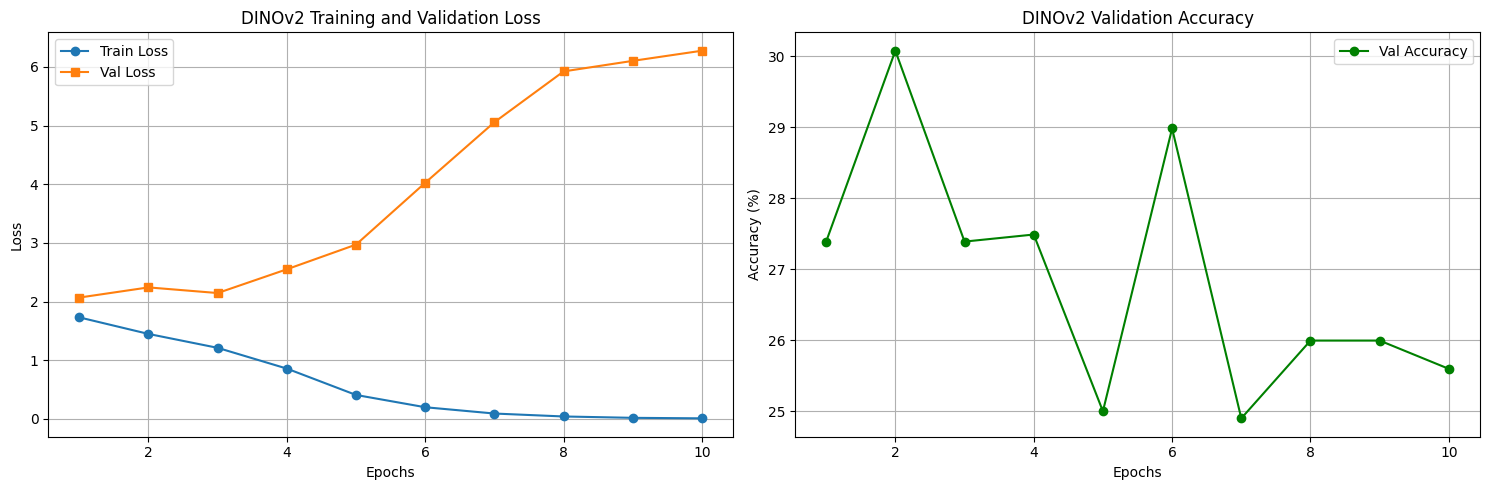


✓ DINOv2 training complete! Run model_evaluation.ipynb to evaluate.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import timm
from pathlib import Path
import os
from torch.cuda.amp import autocast, GradScaler
import time

# GPU check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# ------------------------
# Custom RSUD Dataset for DINOv2
# ------------------------
class RSUDDatasetDINOv2(Dataset):
    """RSUD dataset for DINOv2 classification"""
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = Path(img_dir)
        self.label_dir = Path(label_dir)
        self.transform = transform
        
        # Get all image files
        self.image_files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))])
        
        # RSUD class names (13 classes)
        self.classes = [
            'Dilarang Berhenti', 'Dilarang Parkir', 'Dilarang Masuk',
            'Bahaya', 'Lampu Lalu Lintas Merah', 'Batas Kecepatan',
            'Wajib', 'Larangan Belok', 'Zona Pejalan Kaki',
            'Petunjuk Arah', 'Rambu Informasi', 'Hati-hati',
            'Zona Khusus'
        ]
        
        print(f"Found {len(self.image_files)} images in {img_dir}")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = self.img_dir / img_name
        image = Image.open(img_path).convert('RGB')
        
        # Load YOLO format label (get first class only for classification)
        label_name = img_name.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = self.label_dir / label_name
        
        label = 0  # default
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                line = f.readline().strip()
                if line:
                    parts = line.split()
                    if len(parts) >= 1:
                        label = int(parts[0])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# ------------------------
# OPTIMIZED Dataset Setup
# ------------------------
base_path = Path("F:/skills-copilot-codespaces-vscode/thesis/rsuddataset/rsud20k")

print(f"\nChecking dataset paths:")
print(f"Base: {base_path.exists()} - {base_path}")

# OPTIMIZATION: Use 224x224 images (faster, compatible with patch16 models)
batch_size = 32  # Increased from 16
img_size = 224   # Standard size for patch16 models

# DINOv2 preprocessing
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = RSUDDatasetDINOv2(
    img_dir=base_path / 'images' / 'train',
    label_dir=base_path / 'labels' / 'train',
    transform=transform
)

val_dataset = RSUDDatasetDINOv2(
    img_dir=base_path / 'images' / 'val',
    label_dir=base_path / 'labels' / 'val',
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

num_classes = len(train_dataset.classes)
print(f"\nDataset loaded:")
print(f"  Classes ({num_classes}): {train_dataset.classes[:3]}...")
print(f"  Train samples: {len(train_dataset)}")
print(f"  Val samples: {len(val_dataset)}")
print(f"  Batch size: {batch_size}")
print(f"  Image size: {img_size}x{img_size}")

# ------------------------
# DINOv2 Model (Base with patch16 for 224x224 images)
# ------------------------
print("\nCreating DINOv2 model...")
# FIXED: Use patch16 variant which accepts 224x224 images
model = timm.create_model('vit_base_patch16_224.dino', pretrained=True, num_classes=num_classes)
model = model.to(device)
print(f"✓ DINOv2 model created with {sum(p.numel() for p in model.parameters()):,} parameters")

# ------------------------
# Loss & Optimizer
# ------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)

# OPTIMIZATION: Fewer epochs (pretrained models converge faster)
num_epochs = 10
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

# OPTIMIZATION: Mixed precision training (2x speedup)
scaler = GradScaler()

# ------------------------
# Output directory
# ------------------------
output_dir = Path(r"F:\skills-copilot-codespaces-vscode\thesis\checkpoints")
output_dir.mkdir(parents=True, exist_ok=True)

# ------------------------
# Optimized Training Loop
# ------------------------
train_losses, val_losses, val_accs = [], [], []
best_val_acc = 0.0

print(f"\n🚀 Starting OPTIMIZED DINOv2 training for {num_epochs} epochs...")
print("="*60)
print("Optimizations enabled:")
print("  • Mixed Precision (FP16) - 2x faster")
print("  • Standard image size (224x224) - Much faster")
print("  • Larger batch size (32 vs 16) - Better GPU utilization")
print("  • DINO pretrained weights - Better features")
print("  Expected: ~3-5 minutes per epoch")
print("="*60)

for epoch in range(num_epochs):
    epoch_start = time.time()
    
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    print(f"\nEpoch {epoch+1}/{num_epochs} - Training...")
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision forward pass
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Mixed precision backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        if (batch_idx + 1) % 100 == 0:
            print(f"  Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    epoch_time = time.time() - epoch_start
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}] (LR: {current_lr:.6f}) - ⏱️ {epoch_time/60:.1f} min")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print("="*60)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), output_dir / "dinov2_best.pth")
        print(f"  ✓ Saved best model (Val Acc: {val_acc:.2f}%)")

# ------------------------
# Save final model
# ------------------------
torch.save(model.state_dict(), output_dir / "dinov2_final.pth")
print(f"\n✓ DINOv2 training completed!")
print(f"  Best validation accuracy: {best_val_acc:.2f}%")
print(f"  Models saved to: {output_dir.absolute()}")

# ------------------------
# Plot training curves
# ------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
ax1.plot(range(1, num_epochs+1), val_losses, label="Val Loss", marker='s')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("DINOv2 Training and Validation Loss")
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(range(1, num_epochs+1), val_accs, label="Val Accuracy", marker='o', color='green')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("DINOv2 Validation Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(output_dir / "dinov2_training_curves.png", dpi=150)
print(f"  Training curves saved to: {output_dir / 'dinov2_training_curves.png'}")
plt.show()

print("\n" + "="*60)
print("✓ DINOv2 training complete! Run model_evaluation.ipynb to evaluate.")
print("="*60)